In [1]:
import numpy as np
import os
import xarray as xr
import xarray.ufuncs as xfun
import sys
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cm_xml_to_matplotlib as cm # Note: this python script must be located in the same folder as the current script
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Setup and Import

In [2]:
# Create strings that will be concatenated together to form the path to the file

# List all the hindcast days to be loaded. Note, if this changes it could break other parts of the script.
# Note that the first index is zero as there is no hindcast day 0.
hcastDayStr = [None,'01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20']

# These are the base strings of the hindcast file paths/names
dri = '/lss/research/agon-lab/CAM_hindcasts/tratl_cam5.3_ne30_rneale.globe/'
fn = 'tratl_cam5.3_ne30_rneale.globe.fcast.day'

# Initialize variables to hold raw data. They are the length of the previously defined strings.
dataImportLH = [None] * len(hcastDayStr)
dataImportSH = [None] * len(hcastDayStr)

# Create a loading progress bar
print('Starting import. \nImporting hindcast day:', end=' ')

# Using the initialized strings and empty variables, load each dataset
for ii, day in enumerate(hcastDayStr):
    if ii == 0: continue # Skip zero index so that the hindcast indexing is more intuitive 
                         # (e.g. day 7 hindcast is indexed with a 7)
            
    # Update progress bar
    print(ii, end=' ')
    
    # Open the datasets with Xarray
    dataImportLH[ii] = xr.open_dataset(dri+fn+day+'.LHFLX.nc')
    dataImportSH[ii] = xr.open_dataset(dri+fn+day+'.SHFLX.nc')
    
    # Convert the time stamps from the cf convention to the np.datetime64 convention
    # This is done as the datetime64 convention is more easily manipulated and indexed compared to the cf convention
    dataImportLH[ii]['time']  = dataImportLH[ii].indexes['time'].to_datetimeindex(unsafe=True)
    dataImportSH[ii]['time']  = dataImportSH[ii].indexes['time'].to_datetimeindex(unsafe=True)
    
# Load ERA5 data
print('\nImporting ERA5: latent heat', end='...')
driERA5 = '/lss/research/agon-lab/ERA5_ITCZ/'

# Latent heat
fnLHObs = 'latent_flux/highres/ie/ie_2010_daily.nc' # NOTE THIS IS ONLY 2010 DATA
dataImportLHObs = xr.open_dataset(driERA5+fnLHObs)

# Sensible heat
print('sensible heat', end='...')
fnSHObs = 'sensible_flux/highres/isshf_1979-2019_daily.nc'
dataImportSHObs = xr.open_dataset(driERA5+fnSHObs)

# ERA5 land-sea mask
print('mask', end='...')
fnMaskObs  = 'lsm_era5.nc'
dataMaskObs = xr.open_dataset(driERA5+fnMaskObs)

# Reverse the latitude on all ERA5 data so that it matches the hindcast convention (south->north)
dataImportLHObs = dataImportLHObs.reindex(latitude=dataImportLHObs['latitude'][::-1])
dataImportSHObs = dataImportSHObs.reindex(latitude=dataImportSHObs['latitude'][::-1])
dataMaskObs     =     dataMaskObs.reindex(latitude=dataMaskObs[    'latitude'][::-1])

print('import complete!')

Starting import. 
Importing hindcast day: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
Importing ERA5: latent heat...sensible heat...mask...import complete!


# User Inputs Go Here

In [3]:
# ************************************************************************************************
# *************************** USER INPUTS ARE REQUIRED IN THIS CELL ******************************
# ************************************************************************************************

#### Select the date in 'YYYY-MM-DD' format (ISO 8601) ####
_dayOfTheSeason = '2010-02-23'

#### Select the number of days to be time averaged ####
numDayAvg = 6

# Choose region of interest 
lats = -20
latn =  20
lonw = -135 # *** For longitudes west of the Prime Meridian, enter a negative number ***
lone = -90


# ************************************************************************************************
# ************************** User inputs no longer required **************************************
# ************************************************************************************************

# Convert _dayOfTheSeason to datetime64 format
dayOfTheSeason = np.datetime64(_dayOfTheSeason)

#### Select the data within the user defined region of interest

In [4]:
# First, check if the user has requested data that is out of the time bounds of hindcast dataset. If so, intentionally break the code
# Note, it's possible this check might not work more years of hindcast data are added.
# If this happens, just comment this out and be careful not to over extend the bounds as Python might not raise an error
if dayOfTheSeason+numDayAvg-1 > dataImportLH[1]['time'][-1] or dayOfTheSeason < dataImportLH[-1]['time'][0]:
    sys.exit("You attemped to access data that is outside of the time bounds of the hindcast dataset :(")
else: # if the check passes, run the correct operational code
    # Initialize empty arrays to contain the refined imported data
    selLH = [None] * len(hcastDayStr)
    selSH = [None] * len(hcastDayStr)
    
# Increase the region of interest for interpolation purposes
_latn = latn+2; _lats = lats-2
_lonw = lonw-2; _lone = lone+2

# Iterate through each hindcast day and select the data in the region of interest.
# In the same step, take a temporal average over the user specified numDayAvg.
# The iteration starts at 1 to agree with the indexing convention of the hindcast days (starting with 1)
for ii in range(1, len(hcastDayStr)):
    
    # Use isel to exclude the first time index. 
    # This is due to the hindcast time stamps representing the cumulative data for three hours prior to the time stamp
    # Add 360 to the longitude to agree with indexes
    selLH[ii] = dataImportLH[ii].sel(time=slice(dayOfTheSeason, dayOfTheSeason+numDayAvg), 
                                     lat=slice(_lats, _latn), lon=slice(_lonw+360, _lone+360)
                                     ).isel({'time':slice(1,None)}).mean('time', keep_attrs=True)
    selSH[ii] = dataImportSH[ii].sel(time=slice(dayOfTheSeason, dayOfTheSeason+numDayAvg), 
                                     lat=slice(_lats, _latn), lon=slice(_lonw+360, _lone+360)
                                     ).isel({'time':slice(1,None)}).mean('time', keep_attrs=True)

# Do the same for the obs
selLHObs = dataImportLHObs.sel(time=slice(dayOfTheSeason, dayOfTheSeason+numDayAvg), 
                               latitude=slice(_lats, _latn), 
                               longitude=slice(_lonw+360, _lone+360)).mean('time', keep_attrs=True)
selSHObs = dataImportSHObs.sel(time=slice(dayOfTheSeason, dayOfTheSeason+numDayAvg), 
                               latitude=slice(_lats, _latn), 
                               longitude=slice(_lonw+360, _lone+360)).mean('time', keep_attrs=True)

# For the mask, use the user specified region of interest as the mask is not invlolved in the interpolation 
selMaskObs = dataMaskObs.sel(latitude=slice(lats, latn), longitude=slice(lonw+360, lone+360))

#### Prepare the data to be plotted

In [5]:
# Prepare the mask. Ceiling the data so that the land location is over estimated
plotMaskObs = xfun.ceil(selMaskObs.mean(dim='time', keep_attrs=True)['lsm'])

# Initialize lists for hindcast data
plotLH    = [None] * len(selLH)
plotSH    = [None] * len(selSH)

# Interpolate the hindcast dataset to the ERA5 spatial resolution. 
# This is done so that so that error plots can be generated
for ii in range(1,len(hcastDayStr)):
       
    # Set fill value argument to none so that the interpolation function will also extrapolate
    plotLH[ii]  = selLH[ii].interp({'lat':selLHObs['latitude' ].values, 
                                    'lon':selLHObs['longitude'].values}, kwargs={"fill_value":None})
    plotSH[ii]  = selSH[ii].interp({'lat':selSHObs['latitude' ].values, 
                                    'lon':selSHObs['longitude'].values}, kwargs={"fill_value":None})
    
    # Cut off the end points of the interpolated dataset
    plotLH[ii] = plotLH[ii].sel(lat=slice(lats, latn), lon=slice(lonw+360, lone+360))
    plotSH[ii] = plotSH[ii].sel(lat=slice(lats, latn), lon=slice(lonw+360, lone+360)) 
    
    # Add a land-sea mask to the datasets
    plotLH[ii].coords['mask'] = (('lat', 'lon'), plotMaskObs)
    plotSH[ii].coords['mask'] = (('lat', 'lon'), plotMaskObs)

# Create multi-day averages. This is done by....
# Convert the plotVARIABLE list into a numPy array (that stores objects). Iterate over 5 day periods. Take an average of that 5 day period. 
# Store each of these averages in a list as ii iterates in range(1,20,5).
plotLHMultiDay  = [np.array(plotLH , dtype=object)[ii:ii+5].mean() for ii in range(1,20,5)]
plotSHMultiDay  = [np.array(plotSH , dtype=object)[ii:ii+5].mean() for ii in range(1,20,5)]
    
# Do the same for obs. 
# Refine the dataset to the user specified region of interest
# Multiply by latent heat of vaporization to get W/m^2. Flip sign of ERA5 data which uses the opposite convention as CAM.
plotLHObs = selLHObs.sel(latitude=slice(lats, latn), longitude=slice(lonw+360,lone+360))*-2.501e6 
plotSHObs = selSHObs.sel(latitude=slice(lats, latn), longitude=slice(lonw+360,lone+360))*-1

# Add a land-sea mask to the dataset
plotLHObs.coords['mask'] = (('latitude', 'longitude'), plotMaskObs)
plotSHObs.coords['mask'] = (('latitude', 'longitude'), plotMaskObs)

# Generate plots

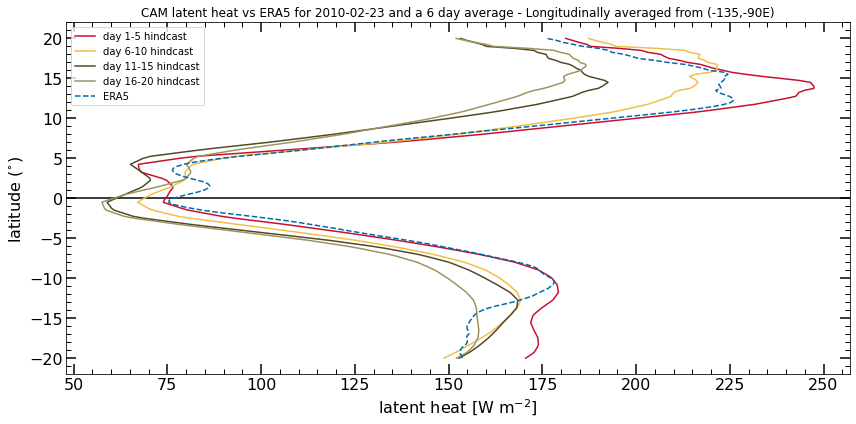

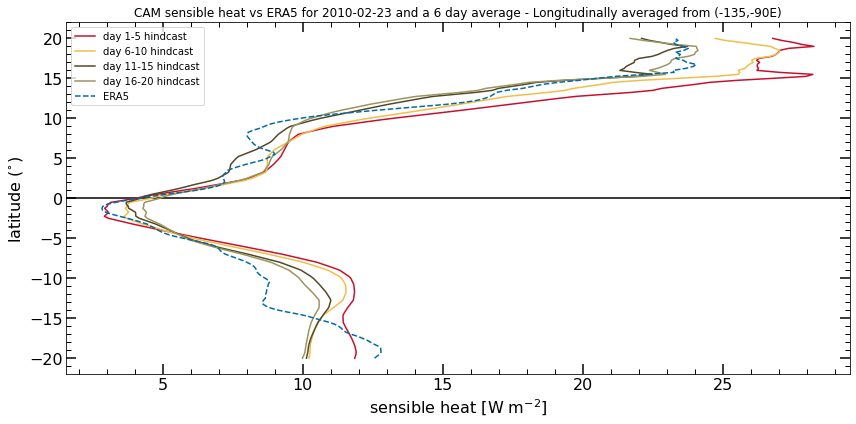

In [6]:
# Plot a comparison between CAM and ERA5

#############################################################################################
#################################### latent heat ############################################
#############################################################################################  

# Set pixel density of plot
_dpi = 100

# Setup the figure
fig = plt.figure(figsize=(12, 6), tight_layout='true')
plt.minorticks_on()
plt.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=16, right='True', top='True')
plt.tick_params(axis='both', which='minor', length= 5, width=1.0, direction='in', labelsize=16, right='True', top='True')
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.axhline(0, color='0', linewidth = 1.5, zorder=-1)
plt.ylabel('latitude $(^{\circ})$', fontsize=16)
plt.xlabel('latent heat [W m$^{-2}$]', fontsize=16)
plotColors = ['#C8102E','#F1BE48','#524727','#9B945F','#8B5B29', '#BE531C'] # Go Cyclones! :)
plotLegend = ['day '+str(ii*5+1)+'->'+str((ii+1)*5)+' hindcast' for ii in range(0,4)]

# Plot CAM data
for ii in range(len(plotLHMultiDay)):
    
    p1 = plt.plot(plotLHMultiDay[ii]['LHFLX'].where(plotLHMultiDay[ii]['mask']==0).mean('lon'), plotLHMultiDay[ii]['lat'], 
                  color = plotColors[ii], label = 'day '+str(ii*5+1)+'-'+str((ii+1)*5)+' hindcast') 

# Plot ERA5 data. Mask land values
p2 = plt.plot(plotLHObs['ie'].where(plotLHObs['mask']==0).mean('longitude'), plotLHObs['latitude'],  
              color='#006BA6', linestyle='dashed', label='ERA5')

plt.title("CAM latent heat vs ERA5 for "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+
          " day average - Longitudinally averaged from ("+str(lonw)+','+str(lone)+'E)')
plt.legend()

# Save figure code
# Check if folder is there. If it is not, make the folder
dir = '/home/jlarson1/'+str(dayOfTheSeason)+' Analysis'
if os.path.isdir(dir) == False:
    os.mkdir(dir)

# # plt.savefig(dir+'/'+str(dayOfTheSeason)+'with'+str(numDayAvg)+'DayAvg'+varName+'LinePlot', bbox_inches='tight', dpi=_dpi)
    
    
#############################################################################################
#################################### sensible heat ##########################################
############################################################################################# 


# Setup the figure
fig = plt.figure(figsize=(12, 6), tight_layout='true')
plt.minorticks_on()
plt.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=16, right='True', top='True')
plt.tick_params(axis='both', which='minor', length= 5, width=1.0, direction='in', labelsize=16, right='True', top='True')
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.axhline(0, color='0', linewidth = 1.5, zorder=-1)
plt.ylabel('latitude $(^{\circ})$', fontsize=16)
plt.xlabel('sensible heat [W m$^{-2}$]', fontsize=16)
plotColors = ['#C8102E','#F1BE48','#524727','#9B945F','#8B5B29', '#BE531C'] # Go Cyclones! :)
plotLegend = ['day '+str(ii*5+1)+'->'+str((ii+1)*5)+' hindcast' for ii in range(0,4)]

# Plot CAM data. Mask land values
for ii in range(len(plotSHMultiDay)):
    
    p1 = plt.plot(plotSHMultiDay[ii]['SHFLX'].where(plotSHMultiDay[ii]['mask']==0).mean('lon'), plotSHMultiDay[ii]['lat'], 
                  color = plotColors[ii], label = 'day '+str(ii*5+1)+'-'+str((ii+1)*5)+' hindcast')    

# Plot ERA5
p2 = plt.plot(plotSHObs['ishf'].where(plotSHObs['mask']==0).mean('longitude'), plotLHObs['latitude'],  
              color='#006BA6', linestyle='dashed', label='ERA5')

plt.title("CAM sensible heat vs ERA5 for "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+
          " day average - Longitudinally averaged from ("+str(lonw)+','+str(lone)+'E)')
plt.legend()
    
    
plt.show()

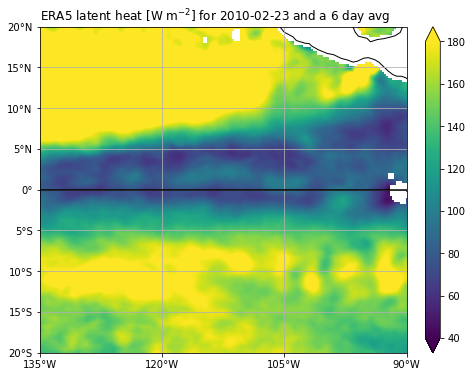

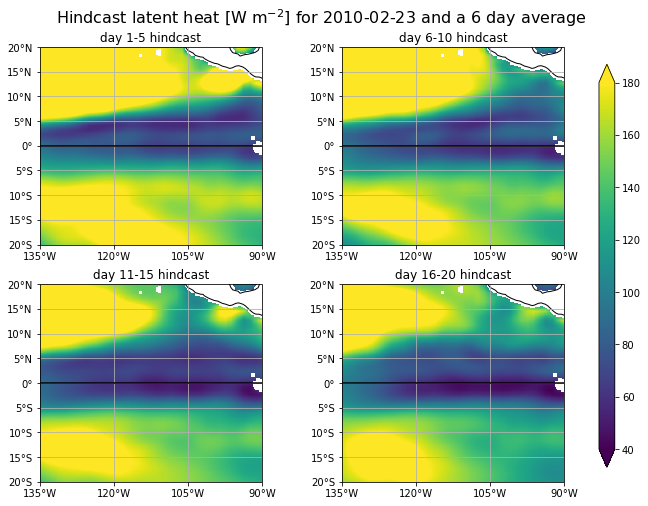

In [7]:
# Create a map plot of the observation data

##### Control plotting variables here #####

# Set the max value of the colorbar
Vmax = 180
Vmin = 40

# Set the density of the pixels in the figure. This also affects the size of the saved figure
_dpi = 200

###########################################

# Create the figure and apply asthetic constraints
fig = plt.figure(figsize=(17, 6)) 

geo_axes = plt.axes(projection=ccrs.PlateCarree())
geo_axes.set_xticks(np.arange(lonw,lone+1,15), crs=ccrs.PlateCarree())
geo_axes.set_yticks(np.arange(lats, latn+1,5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
geo_axes.xaxis.set_major_formatter(lon_formatter)
geo_axes.yaxis.set_major_formatter(lat_formatter)
geo_axes.coastlines(resolution='110m')
geo_axes.gridlines(xlocs=np.arange(lonw,lone+1,15), ylocs=np.arange(lats, latn+1,5))
plt.axhline(0, color='0', linewidth = 1.5)
image_extent = [lonw,lone,lats,latn]

# Plot ERA5 contour plot
IM = geo_axes.imshow(plotLHObs['ie'].where(plotLHObs['mask']==0), extent=image_extent, origin='lower', vmax=Vmax,
                    vmin=Vmin, interpolation='bilinear') 

# Set boundaries of plot
geo_axes.set_xlim([lonw,lone])
geo_axes.set_ylim([lats,latn])

plt.colorbar(IM, ax=geo_axes, orientation='vertical', pad=0.02, extend='both')
plt.title("ERA5 latent heat [W m$^{-2}$] for "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+" day avg", loc='left')
    
plt.show()

###########################################################################################

# Plot four subplots for each hindcast day

###########################################################################################

# Set border of precip data
image_extent = [lonw,lone,lats,latn]

# Pre-generate the subplots with a PlateCarree projection
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Iterate through the subplots
for ii in range(len(plotLHMultiDay)):
    
    # Plot CAM data. Mask land values
    im = axes.flat[ii].imshow(plotLHMultiDay[ii]['LHFLX'].where(plotLHMultiDay[ii]['mask']==0), extent=image_extent, 
                              origin='lower', vmax=Vmax, vmin=Vmin)

    # Set boundaries of graphs
    axes.flat[ii].set_xlim([lonw,lone])
    axes.flat[ii].set_ylim([lats,latn]) # Use user specified lat values
    
    # Set asthetic constraints of the plot
    axes.flat[ii].set_xticks(np.arange(lonw,lone+1,15), crs=ccrs.PlateCarree())
    axes.flat[ii].set_yticks(np.arange(lats,latn+1,5),  crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axes.flat[ii].xaxis.set_major_formatter(lon_formatter)
    axes.flat[ii].yaxis.set_major_formatter(lat_formatter)
    axes.flat[ii].coastlines(resolution='110m')
    axes.flat[ii].gridlines(xlocs=np.arange(lonw,lone+1,15), ylocs=np.arange(lats,latn+1,5)) 
    axes.flat[ii].title.set_text('day '+str(ii*5+1)+'-'+str((ii+1)*5)+' hindcast')
    axes.flat[ii].axhline(0, color='0', linewidth = 1.5)
    
    
# The following code creates a new axes for the colorbar
fig.subplots_adjust(right=0.825) #0.825
# Add base axis for color bar. Located at 85% from left and 15% from bottom. Width is 2% of figure. Height is 70% of figure.
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) 
fig.colorbar(im, cax=cbar_ax, extend='both')

# Set title for the entire figure
fig.suptitle("Hindcast latent heat [W m$^{-2}$] for "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+" day average",
             size=16,y=0.95)

## Save figure code    
# plt.savefig(dir+'/'+str(dayOfTheSeason)+'with'+str(numDayAvg)+'DayAvgHindcastMapPlot', dpi=_dpi, bbox_inches='tight')

plt.show()

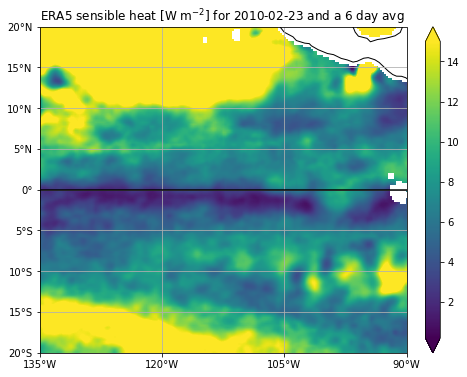

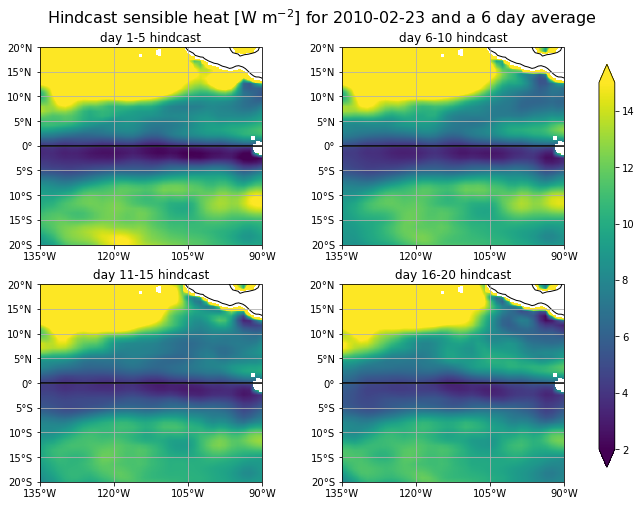

In [8]:
# Create a map plot of the observation data

##### Control plotting variables here #####

# Set the max value of the colorbar
Vmax = 15
Vmin = 2

# Set the density of the pixels in the figure. This also affects the size of the saved figure
_dpi = 200

###########################################

# Create the figure and apply asthetic constraints
fig = plt.figure(figsize=(17, 6)) 

geo_axes = plt.axes(projection=ccrs.PlateCarree())
geo_axes.set_xticks(np.arange(lonw,lone+1,15), crs=ccrs.PlateCarree())
geo_axes.set_yticks(np.arange(lats, latn+1,5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
geo_axes.xaxis.set_major_formatter(lon_formatter)
geo_axes.yaxis.set_major_formatter(lat_formatter)
geo_axes.coastlines(resolution='110m')
geo_axes.gridlines(xlocs=np.arange(lonw,lone+1,15), ylocs=np.arange(lats, latn+1,5))
plt.axhline(0, color='0', linewidth = 1.5)
image_extent = [lonw,lone,lats,latn]

# Plot ERA5 data. Mask land values
IM = geo_axes.imshow(plotSHObs['ishf'].where(plotSHObs['mask']==0), extent=image_extent, origin='lower', vmax=Vmax,
                     interpolation='bilinear') 

# Set boundaries of plot
geo_axes.set_xlim([lonw,lone])
geo_axes.set_ylim([lats,latn])

plt.colorbar(IM, ax=geo_axes, orientation='vertical', pad=0.02, extend='both')
plt.title("ERA5 sensible heat [W m$^{-2}$] for "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+" day avg", loc='left')
    
plt.show()

###########################################################################################

# Plot four subplots for each hindcast day

###########################################################################################

# Set border of precip data
image_extent = [lonw,lone,lats,latn]

# Pre-generate the subplots with a PlateCarree projection
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))


# Iterate through the subplots
for ii in range(len(plotSHMultiDay)):
    
    # Plot CAM data. Mask land values
    im = axes.flat[ii].imshow(plotSHMultiDay[ii]['SHFLX'].where(plotSHMultiDay[ii]['mask']==0), 
                              extent=image_extent, origin='lower', vmax=Vmax, vmin=Vmin)

    # Set boundaries of graphs
    axes.flat[ii].set_xlim([lonw,lone])
    axes.flat[ii].set_ylim([lats,latn]) # Use user specified lat values
    
    # Set asthetic constraints of the plot
    axes.flat[ii].set_xticks(np.arange(lonw,lone+1,15), crs=ccrs.PlateCarree())
    axes.flat[ii].set_yticks(np.arange(lats,latn+1,5),  crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axes.flat[ii].xaxis.set_major_formatter(lon_formatter)
    axes.flat[ii].yaxis.set_major_formatter(lat_formatter)
    axes.flat[ii].coastlines(resolution='110m')
    axes.flat[ii].gridlines(xlocs=np.arange(lonw,lone+1,15), ylocs=np.arange(lats,latn+1,5)) 
    axes.flat[ii].title.set_text('day '+str(ii*5+1)+'-'+str((ii+1)*5)+' hindcast')
    axes.flat[ii].axhline(0, color='0', linewidth = 1.5)
    
# The following code creates a new axes for the colorbar
fig.subplots_adjust(right=0.825) #0.825
# Add base axis for color bar. Located at 85% from left and 15% from bottom. Width is 2% of figure. Height is 70% of figure.
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) 
fig.colorbar(im, cax=cbar_ax, extend='both')

# Set title for the entire figure
fig.suptitle("Hindcast sensible heat [W m$^{-2}$] for "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+" day average",
             size=16,y=0.95)

## Save figure code    
# plt.savefig(dir+'/'+str(dayOfTheSeason)+'with'+str(numDayAvg)+'DayAvgHindcastMapPlot', dpi=_dpi, bbox_inches='tight')

plt.show()

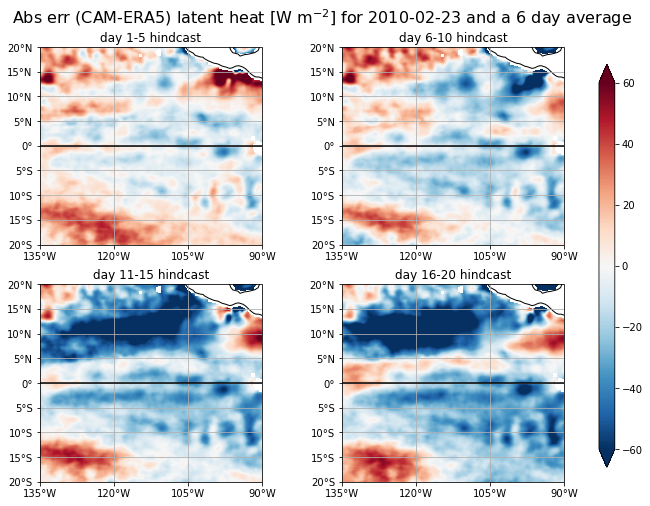

In [9]:
##### Control plotting variables here #####

# Set the max value of the colorbar
Vmax = 60

###########################################

# Set border of precip data
image_extent = [lonw,lone,lats,latn]

# Pre-generate the subplots with a PlateCarree projection
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Iterate through the subplots
for ii in range(len(plotLHMultiDay)):

    # Plot CAM-ERA5. Mask land values
    im = axes.flat[ii].imshow(plotLHMultiDay[ii]['LHFLX'].where(plotLHMultiDay[ii]['mask']==0).values-
                                                                                      plotLHObs['ie'].where(plotLHObs['mask']==0).values, 
                              extent=image_extent, origin='lower', interpolation='bilinear', vmin=-Vmax, vmax=Vmax, cmap='RdBu_r')

    # Set boundaries of graphs
    axes.flat[ii].set_xlim([lonw,lone])
    axes.flat[ii].set_ylim([lats,latn]) # Use user specified lat values 
    
    # Set asthetic constraints of the plot
    axes.flat[ii].set_xticks(np.arange(lonw,lone+1,15), crs=ccrs.PlateCarree())
    axes.flat[ii].set_yticks(np.arange(lats,latn+1,5),  crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axes.flat[ii].xaxis.set_major_formatter(lon_formatter)
    axes.flat[ii].yaxis.set_major_formatter(lat_formatter)
    axes.flat[ii].coastlines(resolution='110m')
    axes.flat[ii].gridlines(xlocs=np.arange(lonw,lone+1,15), ylocs=np.arange(lats,latn+1,5)) 
    axes.flat[ii].title.set_text('day '+str(ii*5+1)+'-'+str((ii+1)*5)+' hindcast')
    axes.flat[ii].axhline(0, color='0', linewidth = 1.5)
    
    
# The following code creates a new axes for the colorbar
fig.subplots_adjust(right=0.825) #0.825
# Add base axis for color bar. Located at 85% from left and 15% from bottom. Width is 2% of figure. Height is 70% of figure.
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) 
fig.colorbar(im, cax=cbar_ax, extend='both')

# Set title for the entire figure
fig.suptitle("Abs err (CAM-ERA5) latent heat [W m$^{-2}$] for "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+" day average",
             size=16,y=0.95)

# Save figure code    
# plt.savefig(dir+'/'+'LHFLX_ErrMap_'+str(dayOfTheSeason)+'with'+str(numDayAvg)+'DayAvg', dpi=_dpi, bbox_inches='tight')

plt.show()

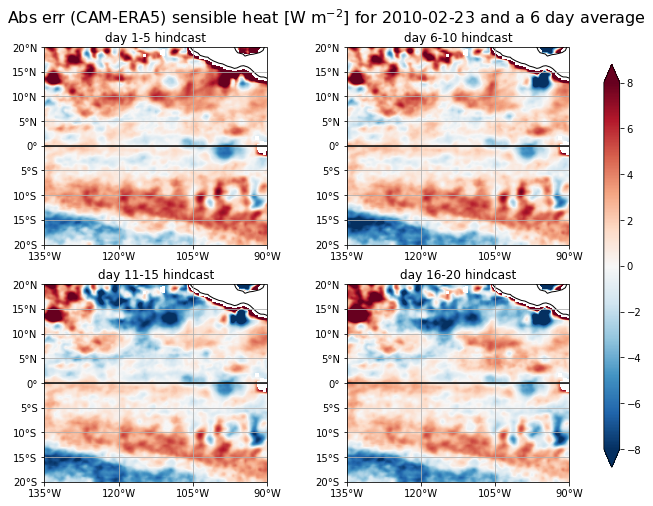

In [10]:
##### Control plotting variables here #####

# Set the max value of the colorbar
Vmax = 8

###########################################

# Set border of precip data
image_extent = [lonw,lone,lats,latn]

# Pre-generate the subplots with a PlateCarree projection
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Iterate through the subplots
for ii in range(len(plotLHMultiDay)):
    
    # Plot CAM-ERA5. Mask land values
    im = axes.flat[ii].imshow(plotSHMultiDay[ii]['SHFLX'].where(plotSHMultiDay[ii]['mask']==0).values-
                                                                                      plotSHObs['ishf'].where(plotSHObs['mask']==0).values, 
                              extent=image_extent, origin='lower', interpolation='bilinear', vmin=-Vmax, vmax=Vmax, cmap='RdBu_r')
    
    # Set boundaries of graphs
    axes.flat[ii].set_xlim([lonw,lone])
    axes.flat[ii].set_ylim([lats,latn]) # Use user specified lat values 
    
    # Set asthetic constraints of the plot
    axes.flat[ii].set_xticks(np.arange(lonw,lone+1,15), crs=ccrs.PlateCarree())
    axes.flat[ii].set_yticks(np.arange(lats,latn+1,5),  crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axes.flat[ii].xaxis.set_major_formatter(lon_formatter)
    axes.flat[ii].yaxis.set_major_formatter(lat_formatter)
    axes.flat[ii].coastlines(resolution='110m')
    axes.flat[ii].gridlines(xlocs=np.arange(lonw,lone+1,15), ylocs=np.arange(lats,latn+1,5)) 
    axes.flat[ii].title.set_text('day '+str(ii*5+1)+'-'+str((ii+1)*5)+' hindcast')
    axes.flat[ii].axhline(0, color='0', linewidth = 1.5)
    
    
# The following code creates a new axes for the colorbar
fig.subplots_adjust(right=0.825) #0.825
# Add base axis for color bar. Located at 85% from left and 15% from bottom. Width is 2% of figure. Height is 70% of figure.
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) 
fig.colorbar(im, cax=cbar_ax, extend='both')

# Set title for the entire figure
fig.suptitle("Abs err (CAM-ERA5) sensible heat [W m$^{-2}$] for "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+" day average",
             size=16,y=0.95)

## Save figure code    
# plt.savefig(dir+'/'+str(dayOfTheSeason)+'with'+str(numDayAvg)+'DayAvgHindcastMapPlot', dpi=_dpi, bbox_inches='tight')

plt.show()